In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision import transforms, models

from PIL import Image

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [2]:
# Root of the repo
PROJECT_ROOT = "."

# Cropped images directory (already generated)
CROP_ROOT = os.path.join(PROJECT_ROOT, "cropped_features")

In [3]:
model = models.resnet18(weights="IMAGENET1K_V1")
model.fc = torch.nn.Identity()  # remove classifier head
model.eval()

print("Embedding dimension:", model(torch.zeros(1, 3, 224, 224)).shape)

Embedding dimension: torch.Size([1, 512])


In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [4]:
def get_embedding(img_path):
    img = Image.open(img_path).convert("RGB")
    x = transform(img).unsqueeze(0)

    with torch.no_grad():
        emb = model(x)

    return emb.squeeze().numpy()  # (512,)

In [5]:
def load_region_embeddings(region_dir):
    X, y = [], []

    for label in os.listdir(region_dir):
        label_dir = os.path.join(region_dir, label)
        if not os.path.isdir(label_dir):
            continue

        for fname in os.listdir(label_dir):
            img_path = os.path.join(label_dir, fname)
            try:
                emb = get_embedding(img_path)
                X.append(emb)
                y.append(label)
            except:
                continue

    return np.array(X), np.array(y)

In [6]:
def load_binary_region_task(region, positive_attr):
    """
    region: e.g. 'eyes'
    positive_attr: e.g. 'Arched_Eyebrows'
    """
    region_dir = os.path.join("cropped_features", region)

    X, y = [], []

    for attr in os.listdir(region_dir):
        attr_dir = os.path.join(region_dir, attr)
        if not os.path.isdir(attr_dir):
            continue

        is_positive = (attr == positive_attr)

        for fname in os.listdir(attr_dir):
            img_path = os.path.join(attr_dir, fname)
            try:
                emb = get_embedding(img_path)
                X.append(emb)
                y.append(1 if is_positive else 0)
            except:
                continue

    return np.array(X), np.array(y)


In [8]:
EYES_DIR = os.path.join(CROP_ROOT, "eyes")

X_eyes, y_eyes = load_region_embeddings(EYES_DIR)

print("Embeddings shape:", X_eyes.shape)
print("Labels:", np.unique(y_eyes, return_counts=True))

Embeddings shape: (988, 512)
Labels: (array(['Arched_Eyebrows', 'Narrow_Eyes'], dtype='<U15'), array([500, 488]))


In [7]:
import os
import numpy as np
# "lips"
REGIONS = ["lips"]#["eyes", "nose", "face", "cheeks"]

for region in REGIONS:
    region_dir = os.path.join("cropped_features", region)

    if not os.path.exists(region_dir):
        print(f"Skipping {region} (no folder)")
        continue

    for attr in os.listdir(region_dir):
        attr_dir = os.path.join(region_dir, attr)
        if not os.path.isdir(attr_dir):
            continue

        X, y = load_binary_region_task(region, attr)

        if len(np.unique(y)) < 2:
            print(f"Skipping {region}/{attr} (single class)")
            continue

        out_prefix = f"{region}_{attr}"

        np.save(f"{out_prefix}_embeddings.npy", X)
        np.save(f"{out_prefix}_labels.npy", y)

        print(f"Saved {out_prefix}: X={X.shape}, positives={y.sum()}")


Skipping lips/Big_Lips (single class)


X shape: (988, 512)
Labels: (array([0, 1]), array([488, 500]))


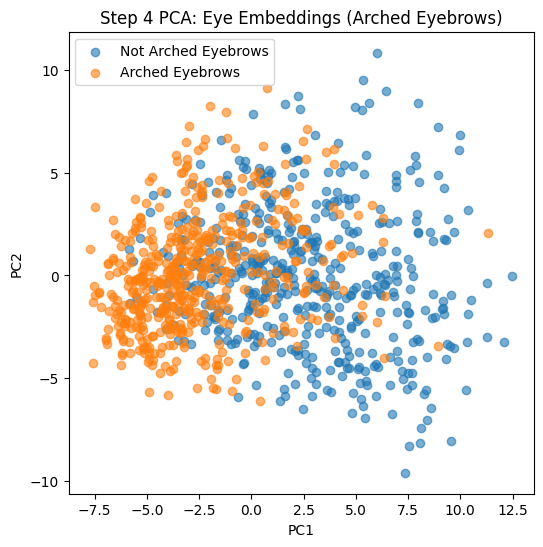

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Load embeddings
X = np.load("eyes_Arched_Eyebrows_embeddings.npy")
y = np.load("eyes_Arched_Eyebrows_labels.npy")

print("X shape:", X.shape)
print("Labels:", np.unique(y, return_counts=True))

# PCA projection
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Plot
plt.figure(figsize=(6,6))
for label in [0, 1]:
    idx = y == label
    plt.scatter(
        X_pca[idx, 0],
        X_pca[idx, 1],
        alpha=0.6,
        label="Arched Eyebrows" if label == 1 else "Not Arched Eyebrows"
    )

plt.legend()
plt.title("Step 4 PCA: Eye Embeddings (Arched Eyebrows)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()
